<a href="https://colab.research.google.com/github/jin573/studyDeepLearning/blob/main/doit7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#다중 분류

#뉴런의 개수는 분류하고자 하는 클래스의 개수와 같다. -> 예측값의 배열은 클래스의 예측 (y_hat1은 강아지, y_hat2는 고양이, y_hat3은 새)

#다중 분류의 문제점
#시그모이드 확률 값의 합이 1이 되어야 함. 다른 확률 값과의 차이가 클 수록 잘 되었다고 볼 수 있음
#합이 1이 되도록 정규화 진행 (소프트맥스)

#다중 분류 손실 함수는 크로스 엔트로피 손실 함수 (로지스틱 손실 함수와 비슷하게 생김)
#(-1)* y_c*log(a_c) 클래스별로 모두 구한 다음 더해야 함 (시그마 계산)
#손실 함수 미분하자 -> -(y-a) 와 같게 나온다



```
def sigmoid(self, z):
  a = 1 / (1 + np.exp(-z))
  return a

def softmax(self, z):
  exp_z = np.exp(z) #행렬 안의 원소를 exp 계산한다
  return exp_z / np.sum(exp_z, axis=1).reshape(-1, 1)
  #각 행의 원소를 모두 더해서 1행으로 나열 후 [..., 6.69, 3.97, ...] 다시 1열로 나열
```
 왜? -> 소프트맥스 함수를 보면 모든 합을 더한 값이 분모가 되기 때문

```
def init_weights(self, n_features, n_classes):
  ...
  self.w2 = np.random.noraml(0, 1, (self.units, n_calsses)) #은닉층의 크기, 클래스의 개수
  self.b2 = np.zeros(n_classes)
```

```
def update_val_loss(self, z_val, y_val):
  ...
  a = self.softmax(z)
  ...
  val_loss = np.sum(-y_val*np.log(a))
```

In [2]:
import numpy as np

In [3]:
class MultiClassNetwork:

    def __init__(self, units=10, batch_size=32, learning_rate=0.1, l1=0, l2=0):
        self.units = units         # 은닉층의 뉴런 개수
        self.batch_size = batch_size     # 배치 크기
        self.w1 = None             # 은닉층의 가중치
        self.b1 = None             # 은닉층의 절편
        self.w2 = None             # 출력층의 가중치
        self.b2 = None             # 출력층의 절편
        self.a1 = None             # 은닉층의 활성화 출력
        self.losses = []           # 훈련 손실
        self.val_losses = []       # 검증 손실
        self.lr = learning_rate    # 학습률
        self.l1 = l1               # L1 손실 하이퍼파라미터
        self.l2 = l2               # L2 손실 하이퍼파라미터

    def forpass(self, x):
        z1 = np.dot(x, self.w1) + self.b1        # 첫 번째 층의 선형 식을 계산합니다
        self.a1 = self.sigmoid(z1)               # 활성화 함수를 적용합니다
        z2 = np.dot(self.a1, self.w2) + self.b2  # 두 번째 층의 선형 식을 계산합니다.
        return z2

    def backprop(self, x, err):
        m = len(x)       # 샘플 개수
        # 출력층의 가중치와 절편에 대한 그래디언트를 계산합니다.
        w2_grad = np.dot(self.a1.T, err) / m
        b2_grad = np.sum(err) / m
        # 시그모이드 함수까지 그래디언트를 계산합니다.
        err_to_hidden = np.dot(err, self.w2.T) * self.a1 * (1 - self.a1)
        # 은닉층의 가중치와 절편에 대한 그래디언트를 계산합니다.
        w1_grad = np.dot(x.T, err_to_hidden) / m
        b1_grad = np.sum(err_to_hidden, axis=0) / m
        return w1_grad, b1_grad, w2_grad, b2_grad

    def sigmoid(self, z):
        z = np.clip(z, -100, None)            # 안전한 np.exp() 계산을 위해
        a = 1 / (1 + np.exp(-z))              # 시그모이드 계산
        return a

    def softmax(self, z):
        # 소프트맥스 함수
        z = np.clip(z, -100, None)            # 안전한 np.exp() 계산을 위해
        exp_z = np.exp(z)
        return exp_z / np.sum(exp_z, axis=1).reshape(-1, 1)

    def init_weights(self, n_features, n_classes):
        self.w1 = np.random.normal(0, 1,
                                   (n_features, self.units))  # (특성 개수, 은닉층의 크기)
        self.b1 = np.zeros(self.units)                        # 은닉층의 크기
        self.w2 = np.random.normal(0, 1,
                                   (self.units, n_classes))   # (은닉층의 크기, 클래스 개수)
        self.b2 = np.zeros(n_classes)

    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        np.random.seed(42)
        self.init_weights(x.shape[1], y.shape[1])    # 은닉층과 출력층의 가중치를 초기화합니다.
        # epochs만큼 반복합니다.
        for i in range(epochs):
            loss = 0
            print('.', end='')
            # 제너레이터 함수에서 반환한 미니배치를 순환합니다.
            for x_batch, y_batch in self.gen_batch(x, y):
                a = self.training(x_batch, y_batch)
                # 안전한 로그 계산을 위해 클리핑합니다.
                a = np.clip(a, 1e-10, 1-1e-10)
                # 로그 손실과 규제 손실을 더하여 리스트에 추가합니다.
                loss += np.sum(-y_batch*np.log(a))
            self.losses.append((loss + self.reg_loss()) / len(x))
            # 검증 세트에 대한 손실을 계산합니다.
            self.update_val_loss(x_val, y_val)

    # 미니배치 제너레이터 함수
    def gen_batch(self, x, y):
        length = len(x)
        bins = length // self.batch_size # 미니배치 횟수
        if length % self.batch_size:
            bins += 1                    # 나누어 떨어지지 않을 때
        indexes = np.random.permutation(np.arange(len(x))) # 인덱스를 섞습니다.
        x = x[indexes]
        y = y[indexes]
        for i in range(bins):
            start = self.batch_size * i
            end = self.batch_size * (i + 1)
            yield x[start:end], y[start:end]   # batch_size만큼 슬라이싱하여 반환합니다.

    def training(self, x, y):
        m = len(x)                # 샘플 개수를 저장합니다.
        z = self.forpass(x)       # 정방향 계산을 수행합니다.
        a = self.softmax(z)       # 활성화 함수를 적용합니다.
        err = -(y - a)            # 오차를 계산합니다.
        # 오차를 역전파하여 그래디언트를 계산합니다.
        w1_grad, b1_grad, w2_grad, b2_grad = self.backprop(x, err)
        # 그래디언트에서 페널티 항의 미분 값을 뺍니다
        w1_grad += (self.l1 * np.sign(self.w1) + self.l2 * self.w1) / m
        w2_grad += (self.l1 * np.sign(self.w2) + self.l2 * self.w2) / m
        # 은닉층의 가중치와 절편을 업데이트합니다.
        self.w1 -= self.lr * w1_grad
        self.b1 -= self.lr * b1_grad
        # 출력층의 가중치와 절편을 업데이트합니다.
        self.w2 -= self.lr * w2_grad
        self.b2 -= self.lr * b2_grad
        return a

    def predict(self, x):
        z = self.forpass(x)          # 정방향 계산을 수행합니다.
        return np.argmax(z, axis=1)  # 가장 큰 값의 인덱스를 반환합니다.

    def score(self, x, y):
        # 예측과 타깃 열 벡터를 비교하여 True의 비율을 반환합니다.
        return np.mean(self.predict(x) == np.argmax(y, axis=1))

    def reg_loss(self):
        # 은닉층과 출력층의 가중치에 규제를 적용합니다.
        return self.l1 * (np.sum(np.abs(self.w1)) + np.sum(np.abs(self.w2))) + \
               self.l2 / 2 * (np.sum(self.w1**2) + np.sum(self.w2**2))

    def update_val_loss(self, x_val, y_val):
        z = self.forpass(x_val)            # 정방향 계산을 수행합니다.
        a = self.softmax(z)                # 활성화 함수를 적용합니다.
        a = np.clip(a, 1e-10, 1-1e-10)     # 출력 값을 클리핑합니다.
        # 크로스 엔트로피 손실과 규제 손실을 더하여 리스트에 추가합니다.
        val_loss = np.sum(-y_val*np.log(a))
        self.val_losses.append((val_loss + self.reg_loss()) / len(y_val))

In [4]:
#MNIST로 분류하기
import tensorflow as tf

In [5]:
tf.__version__

'2.18.0'

In [6]:
(x_train_all, y_train_all), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
print(x_train_all.shape, y_train_all.shape)

(60000, 28, 28) (60000,)


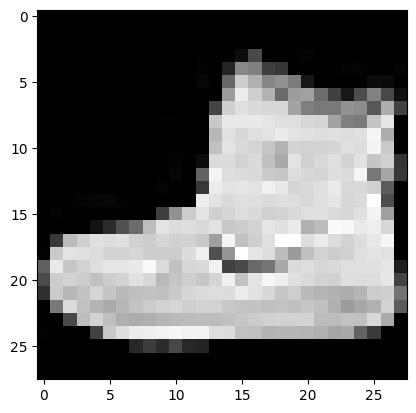

In [9]:
import matplotlib.pyplot as plt
plt.imshow(x_train_all[0], cmap='gray')
plt.show()

In [11]:
print(y_train_all[:10])
class_names = ['티셔츠/윗도리', '바지', '스웨터', '드레스', '코트',
               '샌들', '셔츠', '스니커즈', '가방', '앵클부츠']

[9 0 0 3 0 2 7 2 5 5]


In [12]:
print(class_names[y_train_all[0]])

앵클부츠


In [13]:
np.bincount(y_train_all) #0이 6만개, 1이 6만개..

array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000])

In [14]:
#훈련 세트와 검증 세트 준비
from sklearn.model_selection import train_test_split

In [15]:
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)

In [16]:
np.bincount(y_train)
np.bincount(y_val)

array([1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200])

In [17]:
#표준화로 전처리 (정규화) 다만, 이미지이므로 픽셀의 최댓값으로 나눈다
x_train = x_train / 255
x_val = x_val / 255

In [18]:
#2차원 데이터 셋을 1차원
x_train = x_train.reshape(-1, 784)
x_val = x_val.reshape(-1, 784)
print(x_train.shape, x_val.shape)

(48000, 784) (12000, 784)


In [21]:
#타깃을 원-핫 인코딩으로 바꾸기
#각각의 출력값과 뉴런을 비교해야 됨
#타깃 값과 출력값(예측값) 을 비교해야 하므로 사용하는 방법 -> 원 핫 인코딩
#예를 들어 뉴런의 값이 10이라 예측값 10개가 나온다고 가정
#크기가 10*10인 배열을 만들고 첫 번째 뉴런은 1행의 1열, 두 번째 뉴런은 1행의 2열에 배정 (언제까지나 예시임)
#각 행들을 1열로 바꾸어서 실제 타깃값에서 뺀다면, 그 값이 (y-a)가 됨 -> 그 값이 가장 작은 원소가 타깃값
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
lb.fit_transform([0, 1, 3, 1]) #고유값 -> 0, 1, 3 -> 열이 ( ,3) -> 값이 0, 1, 3, 1 이니까 -> (4, 3)

array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 1, 0]])

In [22]:
tf.keras.utils.to_categorical([0, 1, 3]) #0번째, 1번째, 3번째에 1을 넣어줌. 배열의 크기는 따로 설정되지 않았으므로 3-0+1 = 4

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.]])

In [23]:
y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_val_encoded = tf.keras.utils.to_categorical(y_val)

In [24]:
print(y_train_encoded.shape, y_val_encoded.shape)

(48000, 10) (12000, 10)


In [25]:
print(y_train[0], y_train_encoded[0])

6 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [26]:
fc = MultiClassNetwork(units=100, batch_size=256)
fc.fit(x_train, y_train_encoded,
       x_val=x_val, y_val=y_val_encoded, epochs=40)

........................................

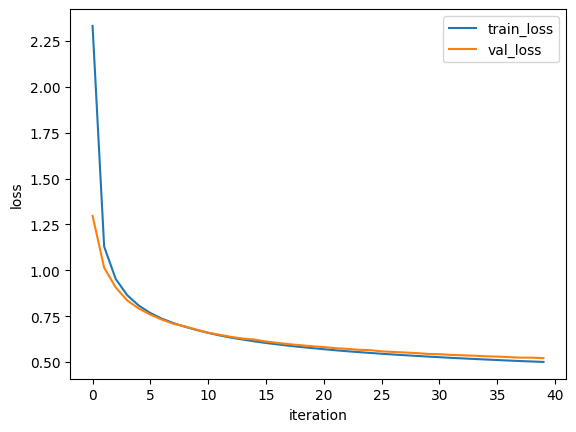

In [27]:
plt.plot(fc.losses)
plt.plot(fc.val_losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [28]:
fc.score(x_val, y_val_encoded)

0.8150833333333334

In [46]:
np.random.permutation(np.arange(12000)%10)

array([4, 6, 3, ..., 0, 6, 6])

In [47]:
np.sum(y_val == np.random.permutation(np.arange(12000)%10)) / 12000

0.10325

In [ ]:
#텐서플로와 케라스를 사용하여 신경망 만들기

In [48]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

In [49]:
model = Sequential()

In [50]:
model.add(Dense(100, activation='sigmoid', input_shape=(784,))) #(뉴런의 개수, 활성화 함수, 입력 배열의 크기를 지정 특성 크기로 지정)
model.add(Dense(10, activation='softmax'))

In [51]:
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy']) #확률적 경사하강법 사용, 크로스엔트로피 손실 함수 사용, 정확도 출력

In [52]:
history = model.fit(x_train, y_train_encoded, epochs=40, validation_data=(x_val, y_val_encoded)) #훈련 데이터, 반복, 검증 데이터

Epoch 1/40
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5060 - loss: 1.7593 - val_accuracy: 0.7348 - val_loss: 0.9708
Epoch 2/40
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7346 - loss: 0.9017 - val_accuracy: 0.7563 - val_loss: 0.7578
Epoch 3/40
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7596 - loss: 0.7364 - val_accuracy: 0.7788 - val_loss: 0.6704
Epoch 4/40
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7790 - loss: 0.6623 - val_accuracy: 0.7906 - val_loss: 0.6182
Epoch 5/40
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.7884 - loss: 0.6197 - val_accuracy: 0.8033 - val_loss: 0.5782
Epoch 6/40
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.7966 - loss: 0.5878 - val_accuracy: 0.8102 - val_loss: 0.5512
Epoch 7/40
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8109 - loss: 0.5544 - val_accuracy: 0.8142 - val_loss: 0.5300
Epoch 8/40
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8126 - loss: 0.5424 

In [53]:
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


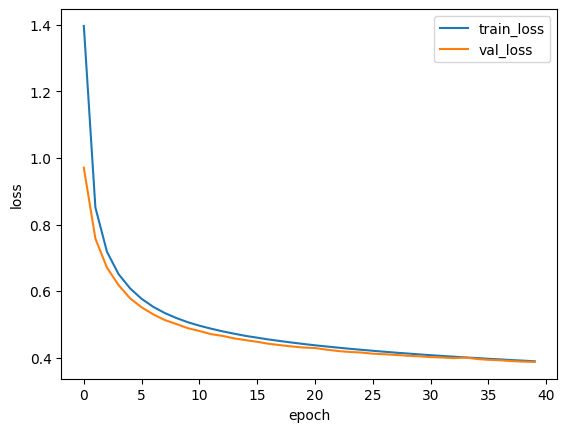

In [54]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

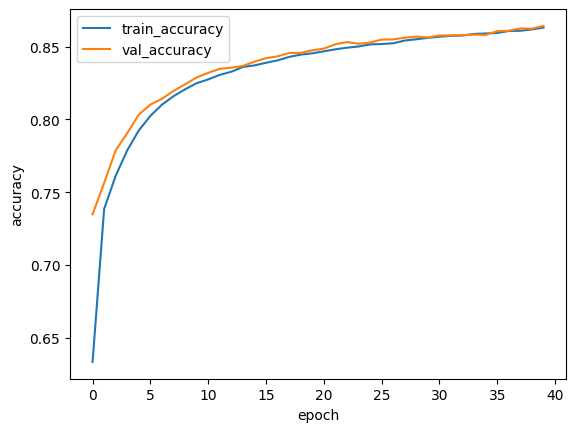

In [55]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()